In [1]:
# 1. Importación de librerías
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings("ignore")

In [6]:
# 2. Lectura de datos
# =========================================
df = pd.read_csv("Analista de datos GOOGL_2006-01-01_to_2018-01-01_M31.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Usamos el precio de cierre ajustado
prices = df['Close']

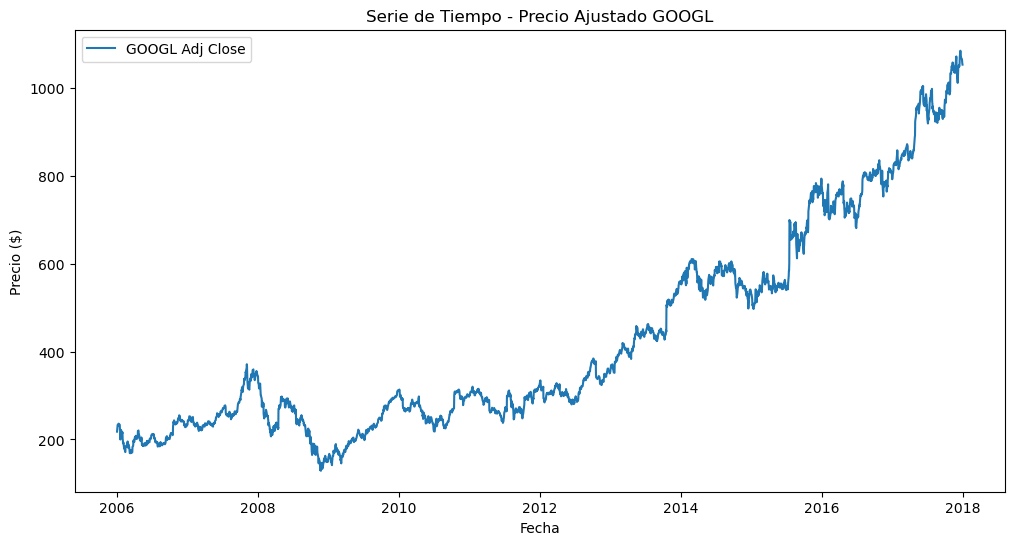

In [7]:
# 3. Visualización simple de la serie temporal
# =========================================
plt.figure(figsize=(12,6))
plt.plot(prices, label='GOOGL Adj Close')
plt.title('Serie de Tiempo - Precio Ajustado GOOGL')
plt.xlabel('Fecha')
plt.ylabel('Precio ($)')
plt.legend()
plt.show()

Reversión a la media -> theta: 0.0001, mu: 9.7770, sigma: 0.0183


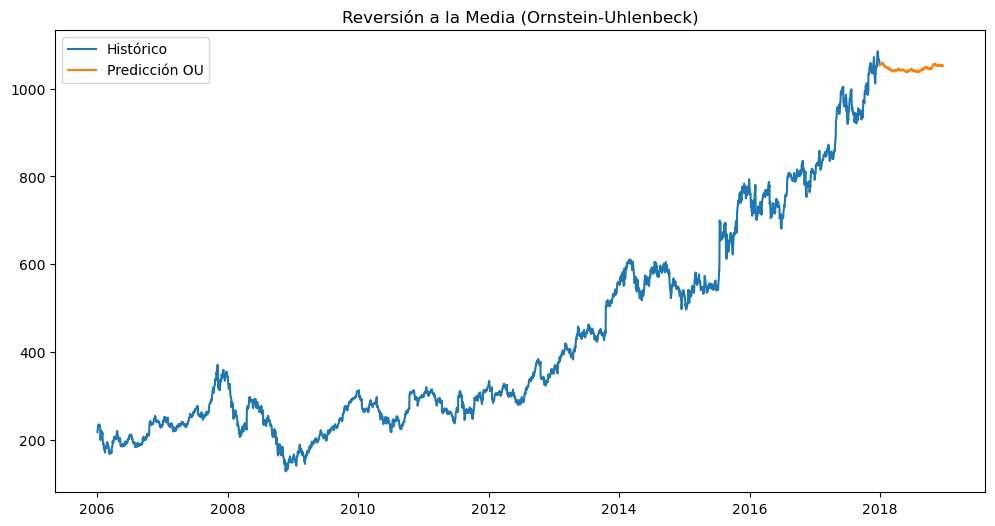

In [12]:
# 4. Modelo de Reversión a la Media (Ornstein–Uhlenbeck)
# =========================================
dt = 1/252  # asumiendo datos diarios de trading
log_prices = np.log(prices)

# Calcular parámetros por regresión lineal
price_diff = log_prices.diff().dropna()
lagged_prices = log_prices.shift(1).dropna()
beta = np.polyfit(lagged_prices, price_diff, 1)
theta = -beta[0]
mu = beta[1] / theta
sigma = np.std(price_diff - beta[0]*lagged_prices - beta[1])

print(f"Reversión a la media -> theta: {theta:.4f}, mu: {mu:.4f}, sigma: {sigma:.4f}")

# Simulación Ornstein-Uhlenbeck
np.random.seed(42)
n_steps = 252
ou_sim = [log_prices.iloc[-1]]
for _ in range(n_steps):
    ou_sim.append(ou_sim[-1] + theta*(mu - ou_sim[-1])*dt + sigma*np.sqrt(dt)*np.random.normal())
ou_sim = np.exp(ou_sim)
plt.figure(figsize=(12,6))
plt.plot(prices.index, prices, label='Histórico')
plt.plot(pd.date_range(prices.index[-1], periods=n_steps+1, freq='B'), ou_sim, label='Predicción OU')
plt.legend()
plt.title('Reversión a la Media (Ornstein-Uhlenbeck)')
plt.show()


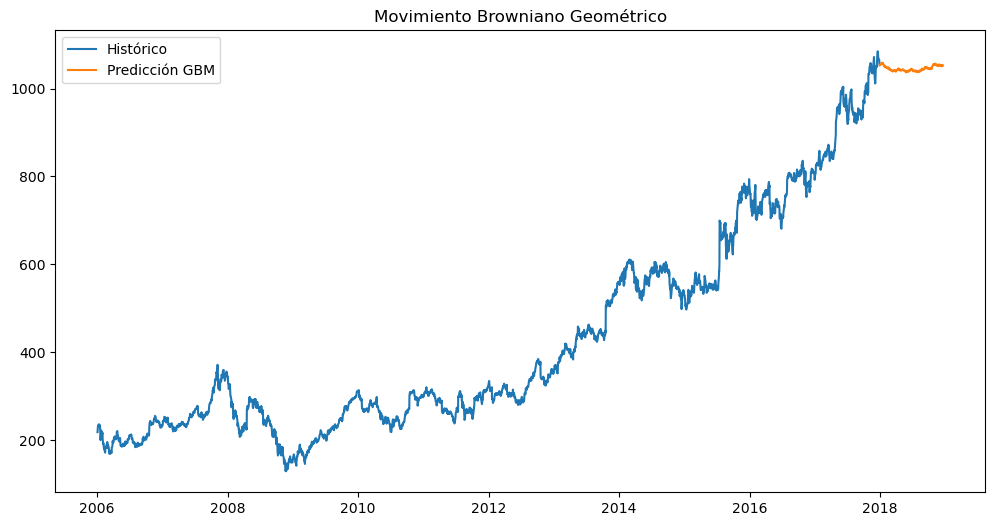

In [13]:
# 5. Movimiento Browniano Geométrico (GBM)
# =========================================
returns = prices.pct_change().dropna()
mu_gbm = returns.mean()
sigma_gbm = returns.std()

np.random.seed(42)
gbm_sim = [prices.iloc[-1]]
for _ in range(n_steps):
    gbm_sim.append(gbm_sim[-1] * np.exp((mu_gbm - 0.5*sigma_gbm**2)*dt + sigma_gbm*np.sqrt(dt)*np.random.normal()))

plt.figure(figsize=(12,6))
plt.plot(prices.index, prices, label='Histórico')
plt.plot(pd.date_range(prices.index[-1], periods=n_steps+1, freq='B'), gbm_sim, label='Predicción GBM')
plt.legend()
plt.title('Movimiento Browniano Geométrico')
plt.show()

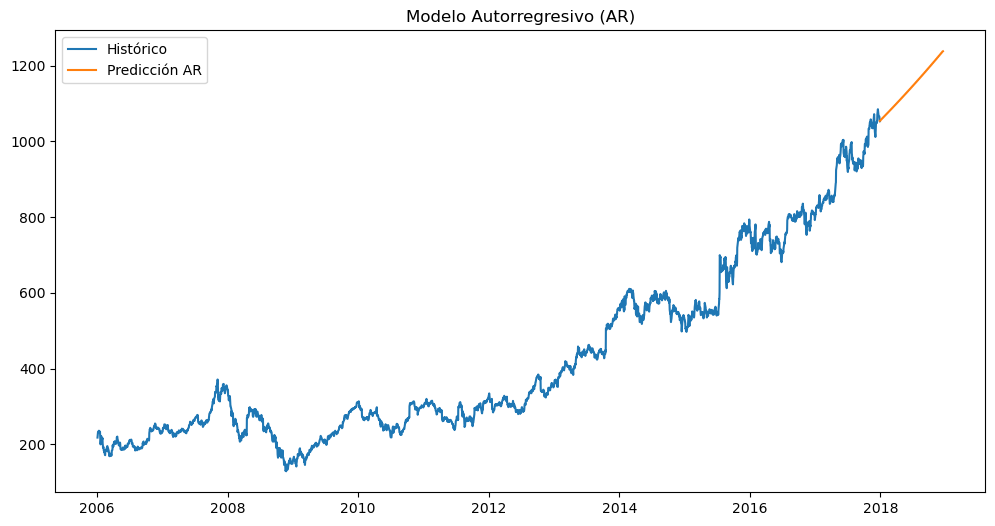

In [14]:
# 6. Modelo Autorregresivo (AR)
# =========================================
ar_model = AutoReg(prices, lags=5).fit()
ar_pred = ar_model.predict(start=len(prices), end=len(prices)+n_steps-1)

plt.figure(figsize=(12,6))
plt.plot(prices.index, prices, label='Histórico')
plt.plot(pd.date_range(prices.index[-1], periods=n_steps, freq='B'), ar_pred, label='Predicción AR')
plt.legend()
plt.title('Modelo Autorregresivo (AR)')
plt.show()

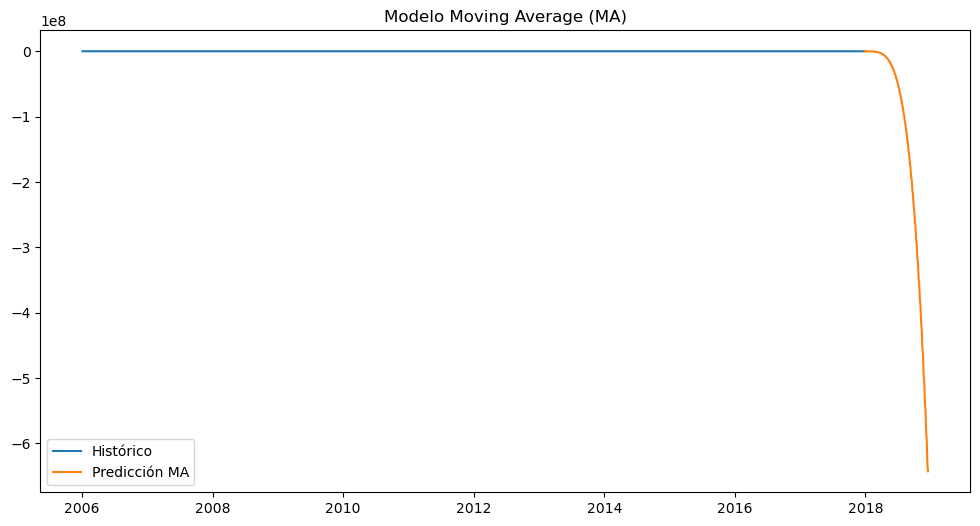

In [16]:
# 7. Modelo Moving Average (MA) con nueva API
# =========================================
from statsmodels.tsa.arima.model import ARIMA

# q = 5 (Moving Average de 5 rezagos)
ma_model = ARIMA(prices, order=(0, 5, 0)).fit()
ma_pred = ma_model.predict(start=len(prices), end=len(prices)+n_steps-1)

plt.figure(figsize=(12,6))
plt.plot(prices.index, prices, label='Histórico')
plt.plot(pd.date_range(prices.index[-1], periods=n_steps, freq='B'), ma_pred, label='Predicción MA')
plt.legend()
plt.title('Modelo Moving Average (MA)')
plt.show()
